In [57]:
# For installing additional packages
import subprocess
import sys

def install(package):
    subprocess.call([sys.executable, "-m", "pip", "install", package])

install('catboost')    
install('xgboost')
install('lightgbm')

In [73]:
import math
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error

import xgboost
import lightgbm as lgb
from catboost import CatBoostRegressor, CatboostError

In [4]:
# Functions

def show_plot(title, data):
    '''
    Show plot
    param data: list of dictinaries ( keys X & Y & label) 
    '''
    for i in range(len(data)): 
        plt.plot(data[i]['X'], data[i]['Y'], label=data[i]['label'])
    
    plt.title(param_title)    
    plt.legend()
    plt.show()
    

In [5]:
# samples - matrix X and vector
X_train = np.array([np.arange(1, 365, 1), np.arange(1, 365, 1)])
y_train = np.array(list(map(lambda x : math.sin(2 * math.pi * x / 365), X_train[:1][0])))

# sin | cos etc. are periodical functions. Period for future prediction
X_period = np.concatenate([
    np.array(np.arange(1, 365, 1)),
    np.array(np.arange(1, 365, 1))
])
X_test = np.array([X_period, np.arange(365, 1093, 1)]) 
y_test = np.array(list(map(lambda x : math.sin(2 * math.pi * x / 365), X_test[:1][0])))

# Transpose matrices
X_train = X_train.transpose()
X_test = X_test.transpose()

In [6]:
# params for model
param_iterations = 10000
param_learning_rate = 0.01
param_depth = 2
param_title = 'iterations={0} | learning_rate={1} | depth={2}'.format(param_iterations, param_learning_rate, param_depth)

explained_variance_score: 0.999496415547008
RMSE: 0.01593606333327519
mean_absolute_error: 0.012687506231770895


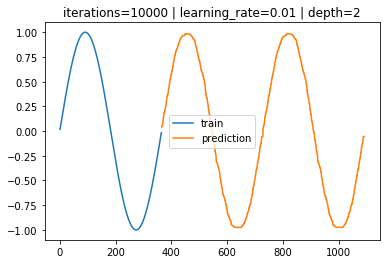

In [18]:
# Catboost

# create model
model_catboost = CatBoostRegressor(
    iterations=param_iterations,
    learning_rate=param_learning_rate,
    depth=param_depth,
    verbose=False
)

# load model if exist 
model_catboost_name = 'catboost.mlmodel'
try:
    model_catboost = model_catboost.load_model(model_catboost_name, format='catboost')
except CatboostError:
    # learning
    print('File \"{0}\" doesn\'t exist \nStart learning ...'.format(model_catboost_name))
    model_catboost.fit(X_train[:,0], y_train)
    
    # save model 
    model_catboost.save_model(model_catboost_name)
    print('Model has been saved to \"{0}\"'.format(model_catboost_name))

    
# prediction
preds_catboost = model_catboost.predict(X_test[:,0])

# error 
print("explained_variance_score: {0}".format(explained_variance_score(preds_catboost,y_test))) 
print("RMSE: {0}".format(math.sqrt(mean_squared_error(preds_catboost, y_test))))
print("mean_absolute_error: {0}".format(mean_absolute_error(preds_catboost, y_test)))

# plot 
show_plot(
    param_title,
    [
        {'X' : X_train[:,1], 'Y' : y_train, 'label' : 'train'},
        {'X' : X_test[:,1], 'Y' : preds_catboost, 'label' : 'prediction'}
    ]
)

explained_variance_score: 0.9999996174228913
RMSE: 0.00043790972467128766
mean_absolute_error: 0.00026466306765510303


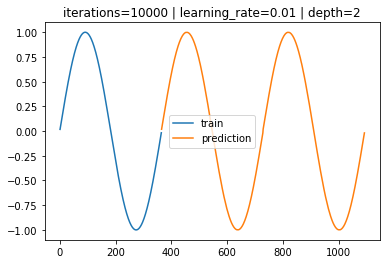

In [55]:
# XGBoost 

# create model 
xgb = xgboost.XGBRegressor(
    n_estimators=param_iterations,
    learning_rate=param_learning_rate,
    max_depth=param_depth
)


# learning
xgb.fit(np.array([X_train[:,0], X_train[:,0]]).transpose() , y_train)

# prediction 
preds_xgb = xgb.predict(np.array([X_test[:,0], X_test[:,0]]).transpose())

# error 
print("explained_variance_score: {0}".format(explained_variance_score(preds_xgb,y_test))) 
print("RMSE: {0}".format(math.sqrt(mean_squared_error(preds_xgb, y_test))))
print("mean_absolute_error: {0}".format(mean_absolute_error(preds_xgb, y_test)))

# plot 
show_plot(
    param_title,
    [
        {'X' : X_train[:,1], 'Y' : y_train, 'label' : 'train'},
        {'X' : X_test[:,1], 'Y' : preds_xgb, 'label' : 'prediction'}
    ]
)


explained_variance_score: 0.997256548966399
RMSE: 0.03700414332552929
mean_absolute_error: 0.01718339281840967


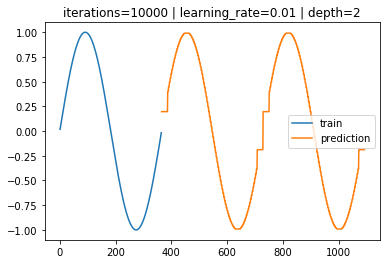

In [90]:
# LightGBM

lgb_train = lgb.Dataset(np.array([X_train[:,0], X_train[:,0]]).transpose(), y_train)

# create model 
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'num_leaves': param_depth,
    'learning_rate': param_learning_rate,
    'verbose': 0
}


# load model if exist 
model_lightGBM_name = 'lightGBM.txt'
lgb_file = Path("./{0}".format(model_lightGBM_name))

if lgb_file.is_file():
    gbm = lgb.Booster(model_file=model_lightGBM_name)
else:
    # learning
    print('File \"{0}\" doesn\'t exist \nStart learning ...'.format(model_lightGBM_name))
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=param_iterations)
    # save model 
    gbm.save_model(model_lightGBM_name)
    print('Model has been saved to \"{0}\"'.format(model_lightGBM_name))



# prediction
preds_lgb = gbm.predict(np.array([X_test[:,0], X_test[:,0]]).transpose(), num_iteration=gbm.best_iteration)

# error 
print("explained_variance_score: {0}".format(explained_variance_score(preds_lgb,y_test))) 
print("RMSE: {0}".format(math.sqrt(mean_squared_error(preds_lgb, y_test))))
print("mean_absolute_error: {0}".format(mean_absolute_error(preds_lgb, y_test)))

# plot 
show_plot(
    param_title,
    [
        {'X' : X_train[:,1], 'Y' : y_train, 'label' : 'train'},
        {'X' : X_test[:,1], 'Y' : preds_lgb, 'label' : 'prediction'}
    ]
)

